In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import netCDF4
from global_land_mask import globe
import matplotlib as mpl
import nc_time_axis
from scipy.interpolate import UnivariateSpline
from matplotlib.widgets import Slider
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic
mpl.rcParams['figure.dpi']= 300
#%matplotlib notebook

In [2]:
a = '/media/rakshith/Seagate Expansion Drive/Good models/CESM2-WACCM/pr_Amon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc'
b = '/media/rakshith/Seagate Expansion Drive/Good models/CESM2-WACCM/pr_Amon_CESM2-WACCM_ssp585_r1i1p1f1_gn_201501-210012.nc'
c = '/media/rakshith/Seagate Expansion Drive/Good models/CESM2-WACCM/prw_Amon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc'
d = '/media/rakshith/Seagate Expansion Drive/Good models/CESM2-WACCM/prw_Amon_CESM2-WACCM_ssp585_r1i1p1f1_gn_201501-210012.nc'
pr = [a,b]
prw = [c,d]
cesmpr = xr.open_mfdataset(pr)
cesmprw = xr.open_mfdataset(prw)
cesm = cesmpr.merge(cesmprw, compat='override')

model2 = '/media/rakshith/Seagate Expansion Drive/Good models/CMCC/*.nc'
cmcc = xr.open_mfdataset(model2)

model3 = '/media/rakshith/Seagate Expansion Drive/Good models/INM-CM5-0/*.nc'
inm = xr.open_mfdataset(model3)

model4 = '/media/rakshith/Seagate Expansion Drive/Good models/MIROC6/*.nc'
miroc = xr.open_mfdataset(model4)

model5 = '/media/rakshith/Seagate Expansion Drive/Good models/NESM3/*.nc'
nesm = xr.open_mfdataset(model5)

model6 = '/media/rakshith/Seagate Expansion Drive/Good models/BCC-CSM2-MR/*.nc'
bcc = xr.open_mfdataset(model6)

model7 = '/media/rakshith/Seagate Expansion Drive/Good models/E3SM-1-0/*.nc'
e3sm = xr.open_mfdataset(model7)

model8 = '/media/rakshith/Seagate Expansion Drive/Good models/GFDL-ESM4/*.nc'
gfdl = xr.open_mfdataset(model8)

model9 = '/media/rakshith/Seagate Expansion Drive/Good models/IPSL-CM6A-LR/*.nc'
ipsl = xr.open_mfdataset(model9)

model10 = '/media/rakshith/Seagate Expansion Drive/Good models/MRI-ESM2-0/*.nc'
mri = xr.open_mfdataset(model10)

model11 = '/media/rakshith/Seagate Expansion Drive/Good models/KACE-1-0-G/*.nc'
kace = xr.open_mfdataset(model11)

model12 = '/media/rakshith/Seagate Expansion Drive/Good models/E3SM-1-1-ECA/*.nc'
eca = xr.open_mfdataset(model12)

/home/rakshith/miniconda3/envs/myenv/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/rakshith/miniconda3/envs/myenv/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/rakshith/miniconda3/envs/myenv/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'prw' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [3]:
models = [cesm, cmcc, inm, miroc, nesm, bcc, e3sm, gfdl, ipsl, mri, kace, eca]
#models = [cmcc]
names = ['CESM-WACCM', 'CMCC-CM2-SR5', 'INM-CM5-0', 'MIROC6', 'NESM3', 'BCC-CSM2-MR', 'E3SM-1-0', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MRI-ESM2-0', 'KACE-1-0-G', 'E3SM-1-1-ECA']

# Ensemble means

In [4]:
region = str(input('Enter the region for comparision\n I=India, Af=South Africa, Am=South America\n'))
                   
if region=='I':
        lat1, lat2, lon1, lon2 = 10, 30, 70, 90
        region='India'
elif region=='Af':
        lat1, lat2, lon1, lon2 = -20, -5, 20, 40
        region='South Africa'
else:
        lat1, lat2, lon1, lon2 = -20, -10, 290, 310
        region='South America'

Enter the region for comparision
 I=India, Af=South Africa, Am=South America
I


In [5]:
sPwat1=np.array([])
sPwat2=np.array([])
sPr1=np.array([])
sPr2=np.array([])
for i in models:
    #jjas = i.time.dt.month.isin(range(6, 10))
    #clim = i.sel(time=jjas) #ds with only JJAS months
    clim=i
    clim2 = clim.sel(lat=slice(lat1,lat2), lon=slice(lon1,lon2))
    
    year1='1990'
    year2='2010'
    year3='2070'
    year4='2090'
    '''
    year1='1959'
    year2='1968'
    year3='2012'
    year4='2021'
    '''
    grid1 = clim2.sel(time=slice(year1, year2))
    grid2 = clim2.sel(time=slice(year3, year4))
    
    l=[]
    for i in grid1.lon:
        if i>180:
            l.append(i-360)
        else:
            l.append(i)
            
    lon_grid, lat_grid = np.meshgrid(l, grid1.lat)
    mask = globe.is_land(lat_grid, lon_grid)
    
    Pwat1 = grid1.prw.where(mask>0).mean(dim=['lat', 'lon']).squeeze()
    Pr1 = 86400*grid1.pr.where(mask>0).mean(dim=['lat', 'lon']).squeeze()
    Pwat2 = grid2.prw.where(mask>0).mean(dim=['lat', 'lon']).squeeze()
    Pr2 = 86400*grid2.pr.where(mask>0).mean(dim=['lat', 'lon']).squeeze()
    
    sPwat1 = np.append(sPwat1, Pwat1.values)
    sPwat2 = np.append(sPwat2, Pwat2.values)
    sPr1 = np.append(sPr1, Pr1.values)
    sPr2 = np.append(sPr2, Pr2.values)

In [6]:
b = np.arange(0,81,2)
bin_means1, bin_edges1, binnumber1 = binned_statistic(sPwat1, sPr1, statistic='mean', bins=b)
bin_means2, bin_edges2, binnumber2 = binned_statistic(sPwat2, sPr2, statistic='mean', bins=b)

X = (bin_edges1[0:-1]+bin_edges1[1:])*0.5 #x axis

In [7]:
PWAT1 = np.array([])
PREC1 = np.array([])
PWAT2 = np.array([])
PREC2 = np.array([])
for i in range(len(X)):
    if np.isnan(bin_means1[i])==False:
        PWAT1 = np.append(PWAT1, X[i])
        PREC1 = np.append(PREC1, bin_means1[i])
    if np.isnan(bin_means2[i])==False:
        PWAT2 = np.append(PWAT2, X[i])
        PREC2 = np.append(PREC2, bin_means2[i])        

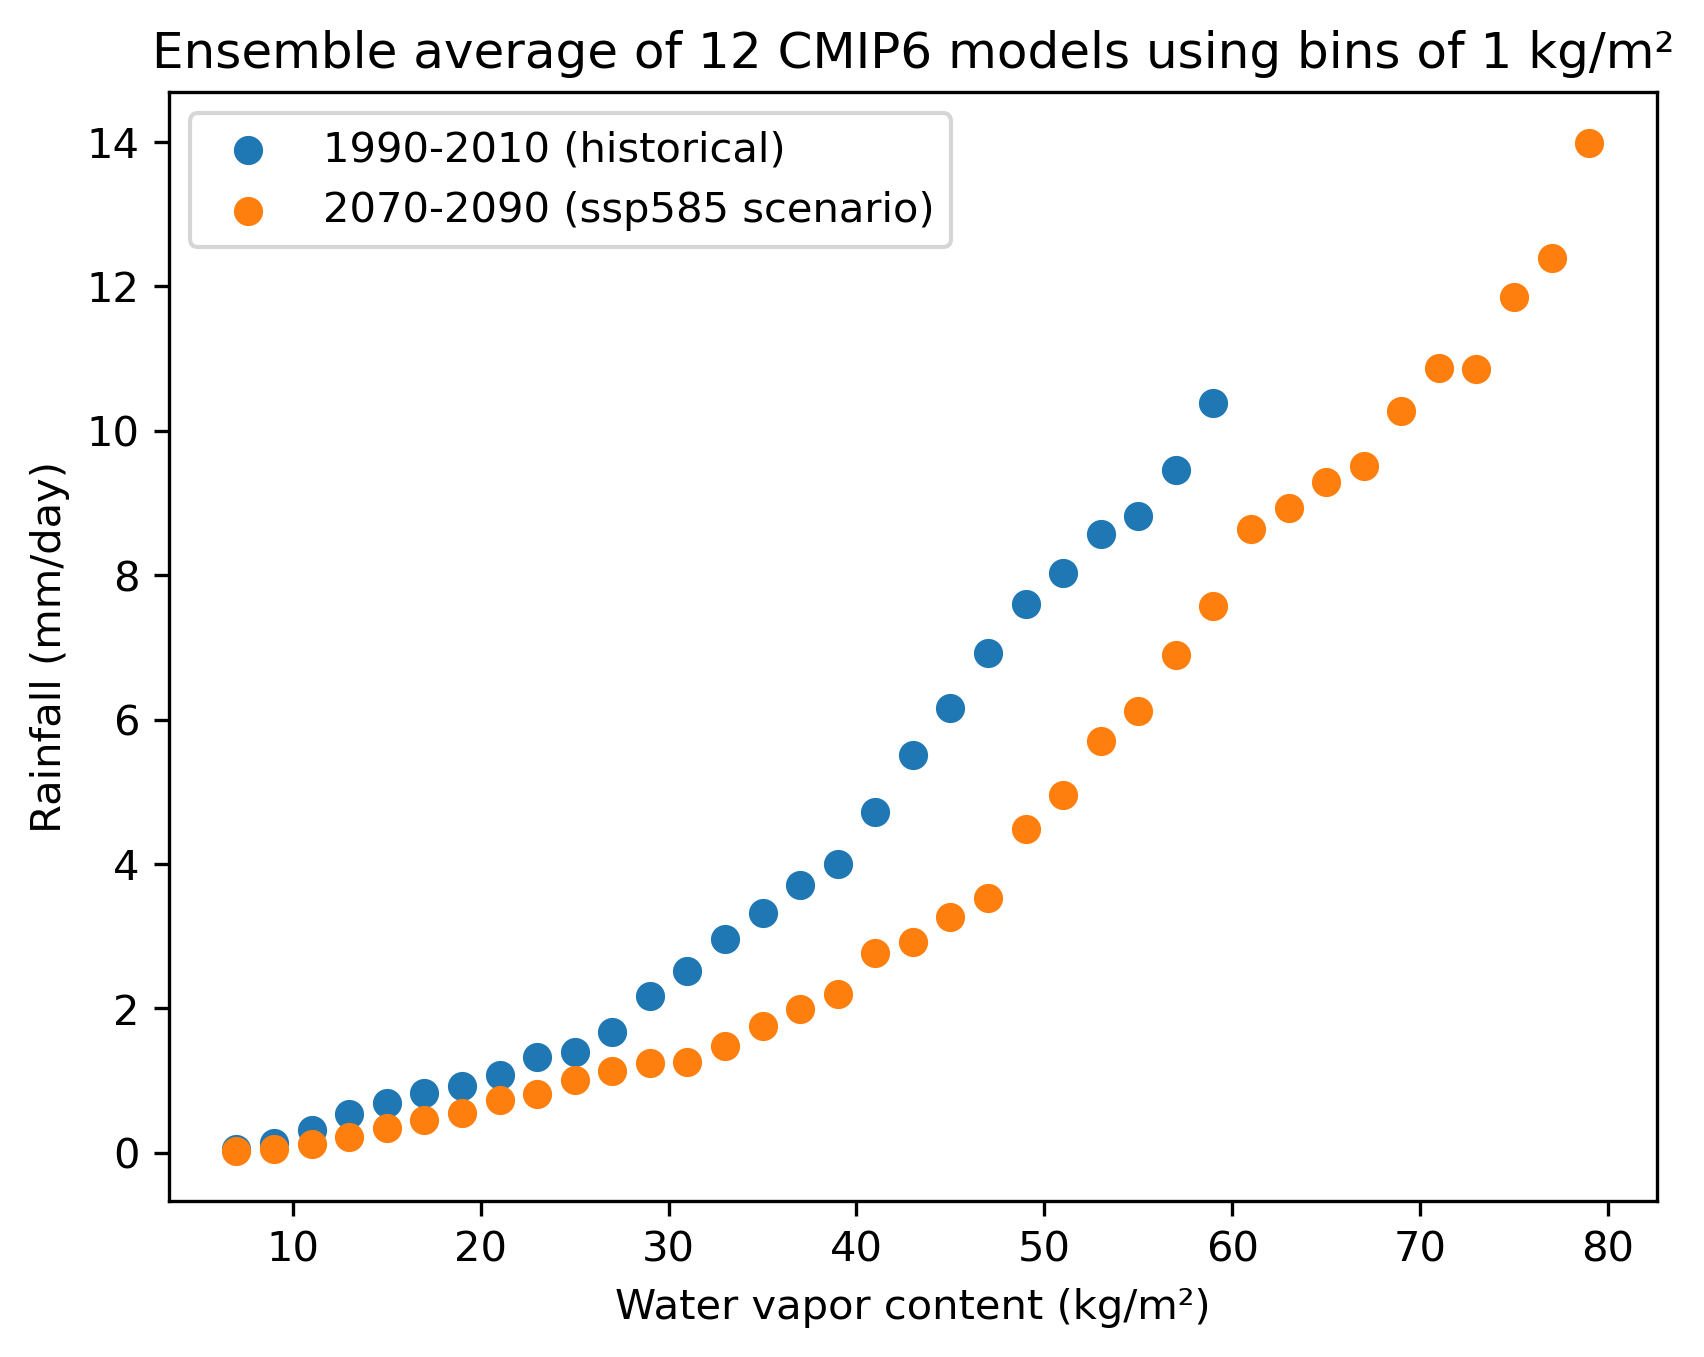

In [8]:
plt.scatter(PWAT1, PREC1)
plt.scatter(PWAT2, PREC2, c='tab:orange')
plt.xlabel('Water vapor content (kg/m\u00b2)')
plt.ylabel('Rainfall (mm/day)')
plt.title('Ensemble average of 12 CMIP6 models using bins of 1 kg/m\u00b2')
plt.legend(['1990-2010 (historical)', '2070-2090 (ssp585 scenario)'])

# Curve Fitting 

In [11]:
x1, y1 = PWAT1, PREC1
x2, y2 = PWAT2, PREC2

#def objective(x, a, b):
#    return a * x/(b-x)

def objective(x, a, b):
    return x/(a-b*x)

#p0 = [5, 100]
p0 = [80, 1]
popt1, _ = curve_fit(objective, x1, y1, p0)

popt2, _ = curve_fit(objective, x2, y2, p0)
a1, b1 = popt1
a2, b2 = popt2
print('y = %.5f * x /(%.5f-x)' % (a1, b1))
print('y = %.5f * x /(%.5f-x)' % (a2, b2))

y_line1 = objective(x1, a1, b1)
y_line2 = objective(x2, a2, b2)

'''
c1, c2 = 3.42, 72.05
c3, c4 = 2.21, 74.68
y_line1 = objective(x1, c1, c2)
y_line2 = objective(x2, c3, c4)
'''

from sklearn.metrics import mean_squared_error
rmse1 = mean_squared_error(y1, y_line1, squared=False)
rmse2 = mean_squared_error(y2, y_line2, squared=False)
print(rmse1)
print(rmse2)

plt.scatter(PWAT1, PREC1)
plt.scatter(PWAT2, PREC2, c='tab:orange')
plt.plot(x1, y_line1, c='r')
plt.plot(x2, y_line2, c='black')
plt.figtext(0.25, 0.6, 'P = Pwat /(%.2f-%.2fPwat)' % (a1, b1))
plt.figtext(0.55, 0.2, 'P = Pwat /(%.2f-%.2fPwat)' % (a2, b2))
#plt.figtext(0.25, 0.6, 'P = %.2fPwat /(%.2f-Pwat)' % (a1, b1))
#plt.figtext(0.55, 0.2, 'P = %.2fPwat /(%.2f-Pwat)' % (a2, b2))
plt.figtext(0.27, 0.55, 'RMSE = %.2f mm/day' % (rmse1))
plt.figtext(0.57, 0.25, 'RMSE = %.2f mm/day' % (rmse2))
plt.xlabel('Water vapor content (kg/m\u00b2)')
plt.ylabel('Rainfall (mm/day)')
plt.legend(['1990-2010', '2070-2090'])
plt.title('Ensemble average of 12 CMIP6 models')

y = 16.94095 * x /(0.19660-x)
y = 19.32986 * x /(0.17598-x)
0.49012079909358625
0.7408325707104465


Text(0.5, 1.0, 'Ensemble average of 12 CMIP6 models')

In [18]:
def objective(x, c1, c2):
    return c1*x/(c2-x)

y_line1 = objective(x1, 3.42, 72.05)

fig =plt.figure()
ax = fig.subplots()
plt.subplots_adjust(bottom = 0.25) #can be used to create rectangular graphs
ax.scatter(PWAT1, PREC1)
#ax.scatter(X2, bin_means2, c='tab:orange')
p, = ax.plot(x1, y_line1, c='r')

slide1 = plt.axes([0.25, 0.15, 0.65, 0.03])
slide2 = plt.axes([0.25, 0.1, 0.65, 0.03]) #xposition, yposition, width, height
const1 = Slider(slide1, 'Constant 1', valmin=1, valmax=15, valinit=3, valstep=0.01)
const2 = Slider(slide2, 'Constant 2', valmin=40, valmax=200, valinit=70, valstep=0.1)

def update(val):
    C1 = const1.val
    C2 = const2.val
    y_line1 = objective(x1, C1, C2)
    p.set_ydata(y_line1)
    #fig.canvas.draw_idle()

const1.on_changed(update)
const2.on_changed(update)
plt.show()

# Cubic fit

In [17]:
def f(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

popt1, _ = curve_fit(f, x1, y1)
a1, b1, c1, d1 = popt1
popt2, _ = curve_fit(f, x2, y2)
a2, b2, c2, d2 = popt2

print('P = %.5f Pwat\u00b3 + %.5f Pwat\u00b2 + %.5f Pwat + %.5f' % (a1, b1, c1, d1))
print('y = %.5f Pwat\u00b3 + %.5f Pwat\u00b2 + %.5f Pwat + %.5f' % (a2, b2, c2, d2))

y_line1 = f(x1, a1, b1, c1, d1)
y_line2 = f(x2, a2, b2, c2, d2)

rmse1 = mean_squared_error(y1, y_line1, squared=False)
print(rmse1)
rmse2 = mean_squared_error(y2, y_line2, squared=False)
print(rmse2)

plt.scatter(PWAT1, PREC1)
plt.scatter(PWAT2, PREC2, c='tab:orange')
plt.plot(x1, y_line1, c='r')
plt.plot(x2, y_line2, c='black')
plt.figtext(0.15, 0.7, 'y = %.5fx\u00b3+%.5fx\u00b2+%.3fx %.3f' % (a1, b1, c1, d1))
plt.figtext(0.30, 0.65, 'RMSE = %.3f mm/day' % (rmse1))
plt.figtext(0.4, 0.15, 'y = %.5fx\u00b3 %.5fx\u00b2+%.3fx %.3f' % (a2, b2, c2, d2))
plt.figtext(0.55, 0.2, 'RMSE = %.3f mm/day' % (rmse2))
plt.xlabel('Water vapor content (kg/m\u00b2)')
plt.ylabel('Rainfall (mm/day)')
plt.legend(['1990-2010', '2070-2090'])
plt.title('Data binned from 10 CMIP6 models')

P = -0.00003 Pwat³ + 0.00601 Pwat² + -0.10122 Pwat + 0.71561
y = -0.00001 Pwat³ + 0.00467 Pwat² + -0.12031 Pwat + 1.00030
0.20151042440782807
0.33404544668845126


Text(0.5, 1.0, 'Data binned from 10 CMIP6 models')

In [18]:
unique1, counts1 = np.unique(binnumber1, return_counts=True)
unique2, counts2 = np.unique(binnumber2, return_counts=True)

Text(0.5, 1.0, 'Distribution of Pwat over 12 CMIP6 models, 2070-2090')

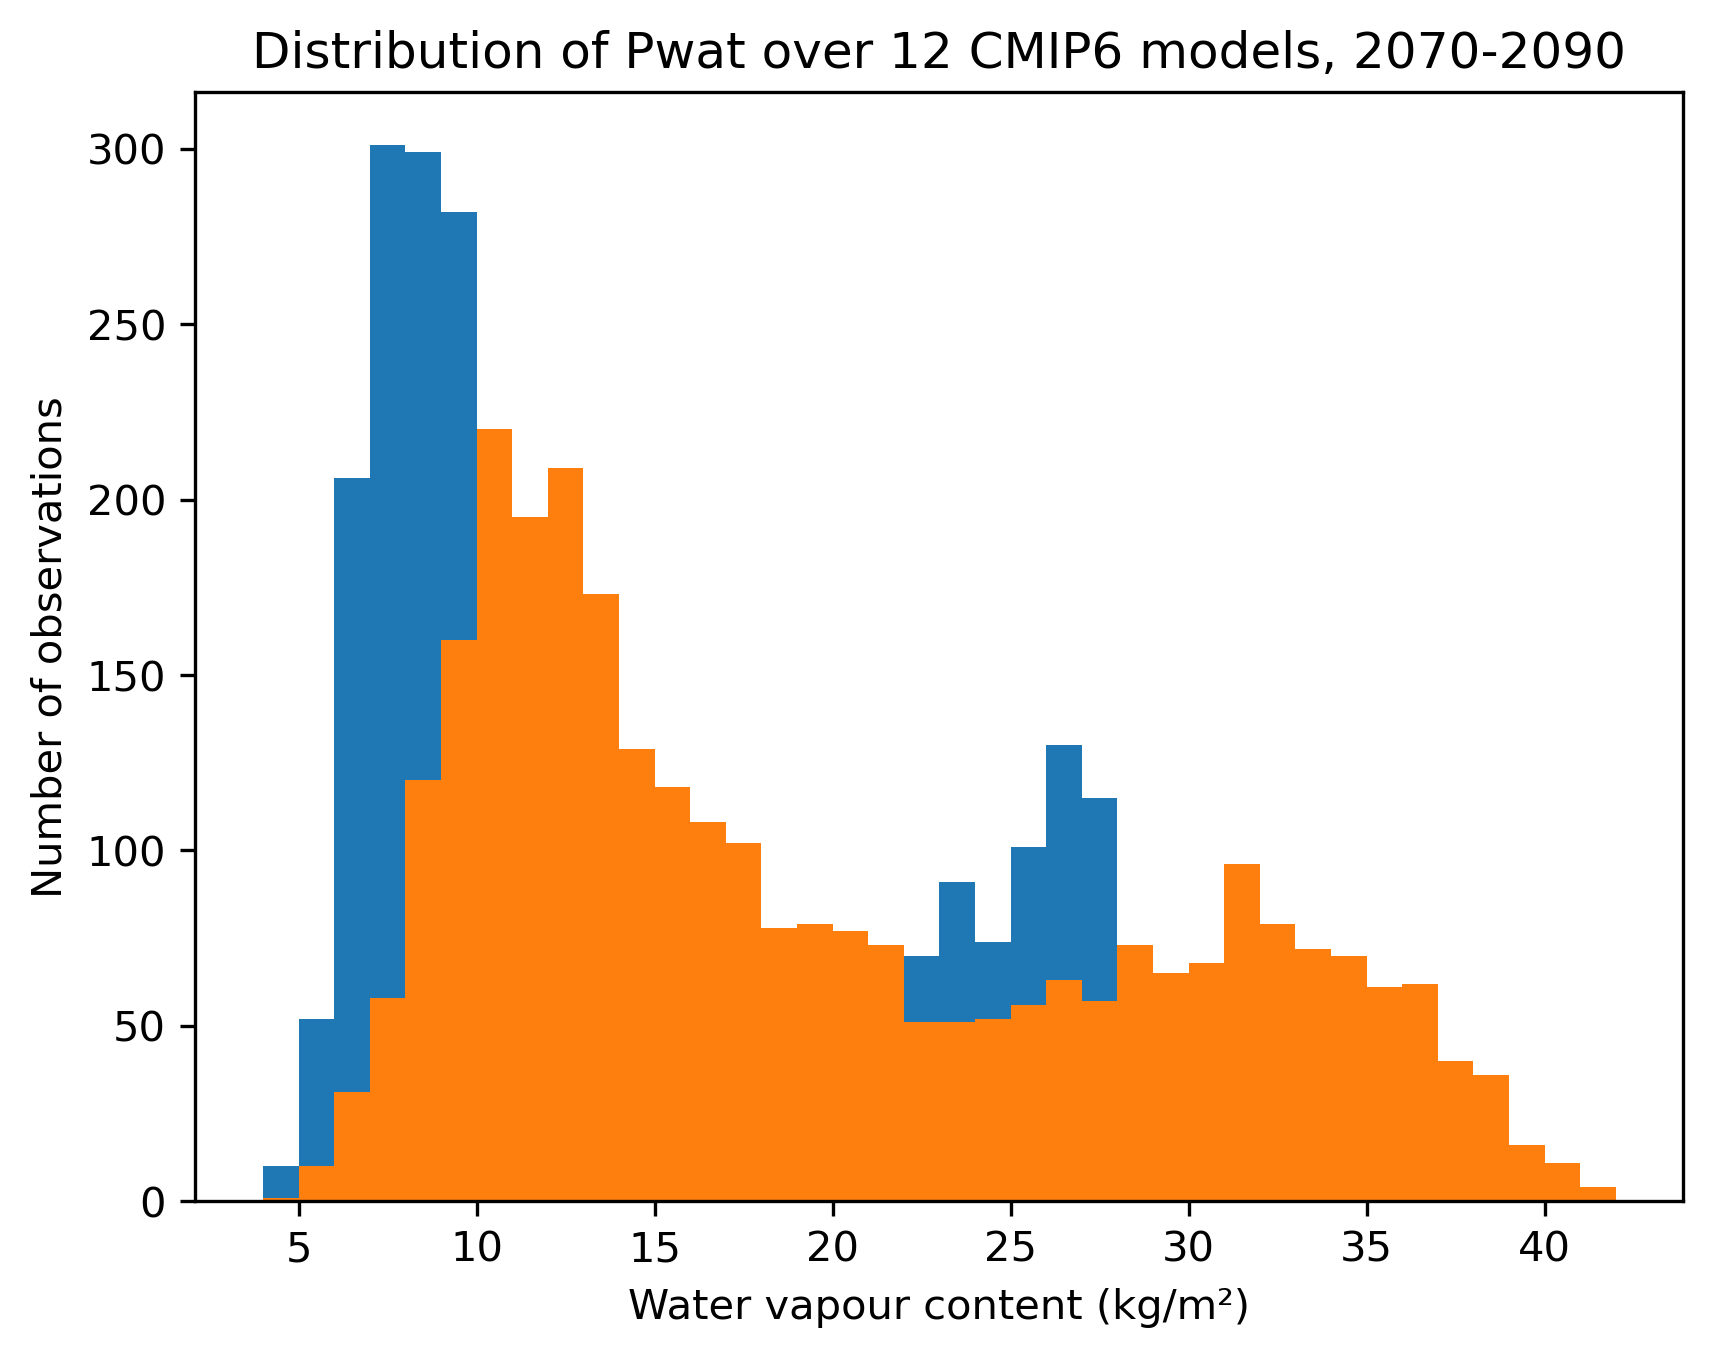

In [20]:
width1 = 0.5
width2 = 1
plt.bar(unique1+width1, counts1, width2)
plt.bar(unique2+width1, counts2, width2)
plt.xlabel('Water vapour content (kg/m\u00b2)')
plt.ylabel('Number of observations')
plt.title('Distribution of Pwat over 12 CMIP6 models, 2070-2090')

# Final binned values for easy access

In [2]:
PWAT1 = np.array([ 6.5,  7.5,  8.5,  9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5,
       17.5, 18.5, 19.5, 20.5, 21.5, 22.5, 23.5, 24.5, 25.5, 26.5, 27.5,
       28.5, 29.5, 30.5, 31.5, 32.5, 33.5, 34.5, 35.5, 36.5, 37.5, 38.5,
       39.5, 40.5, 41.5, 42.5, 43.5, 44.5, 45.5, 46.5, 47.5, 48.5, 49.5,
       50.5, 51.5, 52.5, 53.5, 54.5, 55.5, 56.5, 57.5, 58.5, 59.5])

PREC1 = np.array([ 0.02164731,  0.05541081,  0.07584824,  0.15214206,  0.24091531,
        0.32743519,  0.45902534,  0.57555616,  0.6069085 ,  0.74334525,
        0.82891287,  0.76755693,  0.86775419,  0.91417047,  0.9594613 ,
        1.16874705,  1.13787908,  1.42035466,  1.37989093,  1.33839337,
        1.64107512,  1.56435693,  2.14444429,  2.07652526,  2.37195344,
        2.37372718,  2.85013716,  2.91765555,  3.21243951,  3.39597712,
        3.2300727 ,  3.83075746,  3.56751594,  4.23666258,  4.32422559,
        5.1200299 ,  5.55867735,  5.38161208,  5.95790176,  6.1872523 ,
        6.41547672,  7.19919425,  7.26289204,  7.66216495,  7.80798683,
        7.92265515,  8.60956324,  8.47411101,  9.02982559,  8.54419921,
        9.02057475,  9.96095116, 10.14040969, 11.55955642])

PWAT2 = np.array([ 7.5,  8.5,  9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5,
       18.5, 19.5, 20.5, 21.5, 22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5,
       29.5, 30.5, 31.5, 32.5, 33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5,
       40.5, 41.5, 42.5, 43.5, 44.5, 45.5, 46.5, 47.5, 48.5, 49.5, 50.5,
       51.5, 52.5, 53.5, 54.5, 55.5, 56.5, 57.5, 58.5, 59.5, 60.5, 61.5,
       62.5, 63.5, 64.5, 65.5, 66.5, 67.5, 68.5, 69.5, 70.5, 71.5, 72.5,
       73.5, 74.5, 75.5, 76.5, 77.5, 78.5, 79.5])

PREC2 = np.array([ 0.02876848,  0.03117228,  0.0589896 ,  0.11244886,  0.13021479,
        0.15510281,  0.25547713,  0.28966686,  0.38784228,  0.41689099,
        0.49766914,  0.50495309,  0.60367455,  0.74099969,  0.71431766,
        0.78929758,  0.77579568,  0.91164644,  1.04291552,  0.99975512,
        1.10982498,  1.12473622,  1.37125235,  1.18318168,  1.34767691,
        1.29073291,  1.63698907,  1.81133263,  1.82522925,  2.0180726 ,
        2.18250413,  2.16708911,  2.42090158,  2.70928659,  2.82807162,
        2.76102261,  3.2480507 ,  3.10554112,  3.38548627,  3.38052529,
        3.61723039,  4.63213967,  4.24478315,  4.38445891,  5.49686832,
        5.61327234,  5.910041  ,  6.22271111,  6.03093784,  6.49271115,
        7.26584187,  7.30559285,  7.99480324,  8.71850752,  8.64631863,
        9.31970769,  8.51894436,  9.30413589,  9.31711458,  9.33250366,
        9.77774431,  9.92533679, 10.27356648, 10.6700002 , 10.63960998,
       10.79766403, 10.47085018, 11.59546155, 11.57700297, 12.39385245,
       11.9518098 , 14.12413947, 14.4752006 ])

# Each model seperately

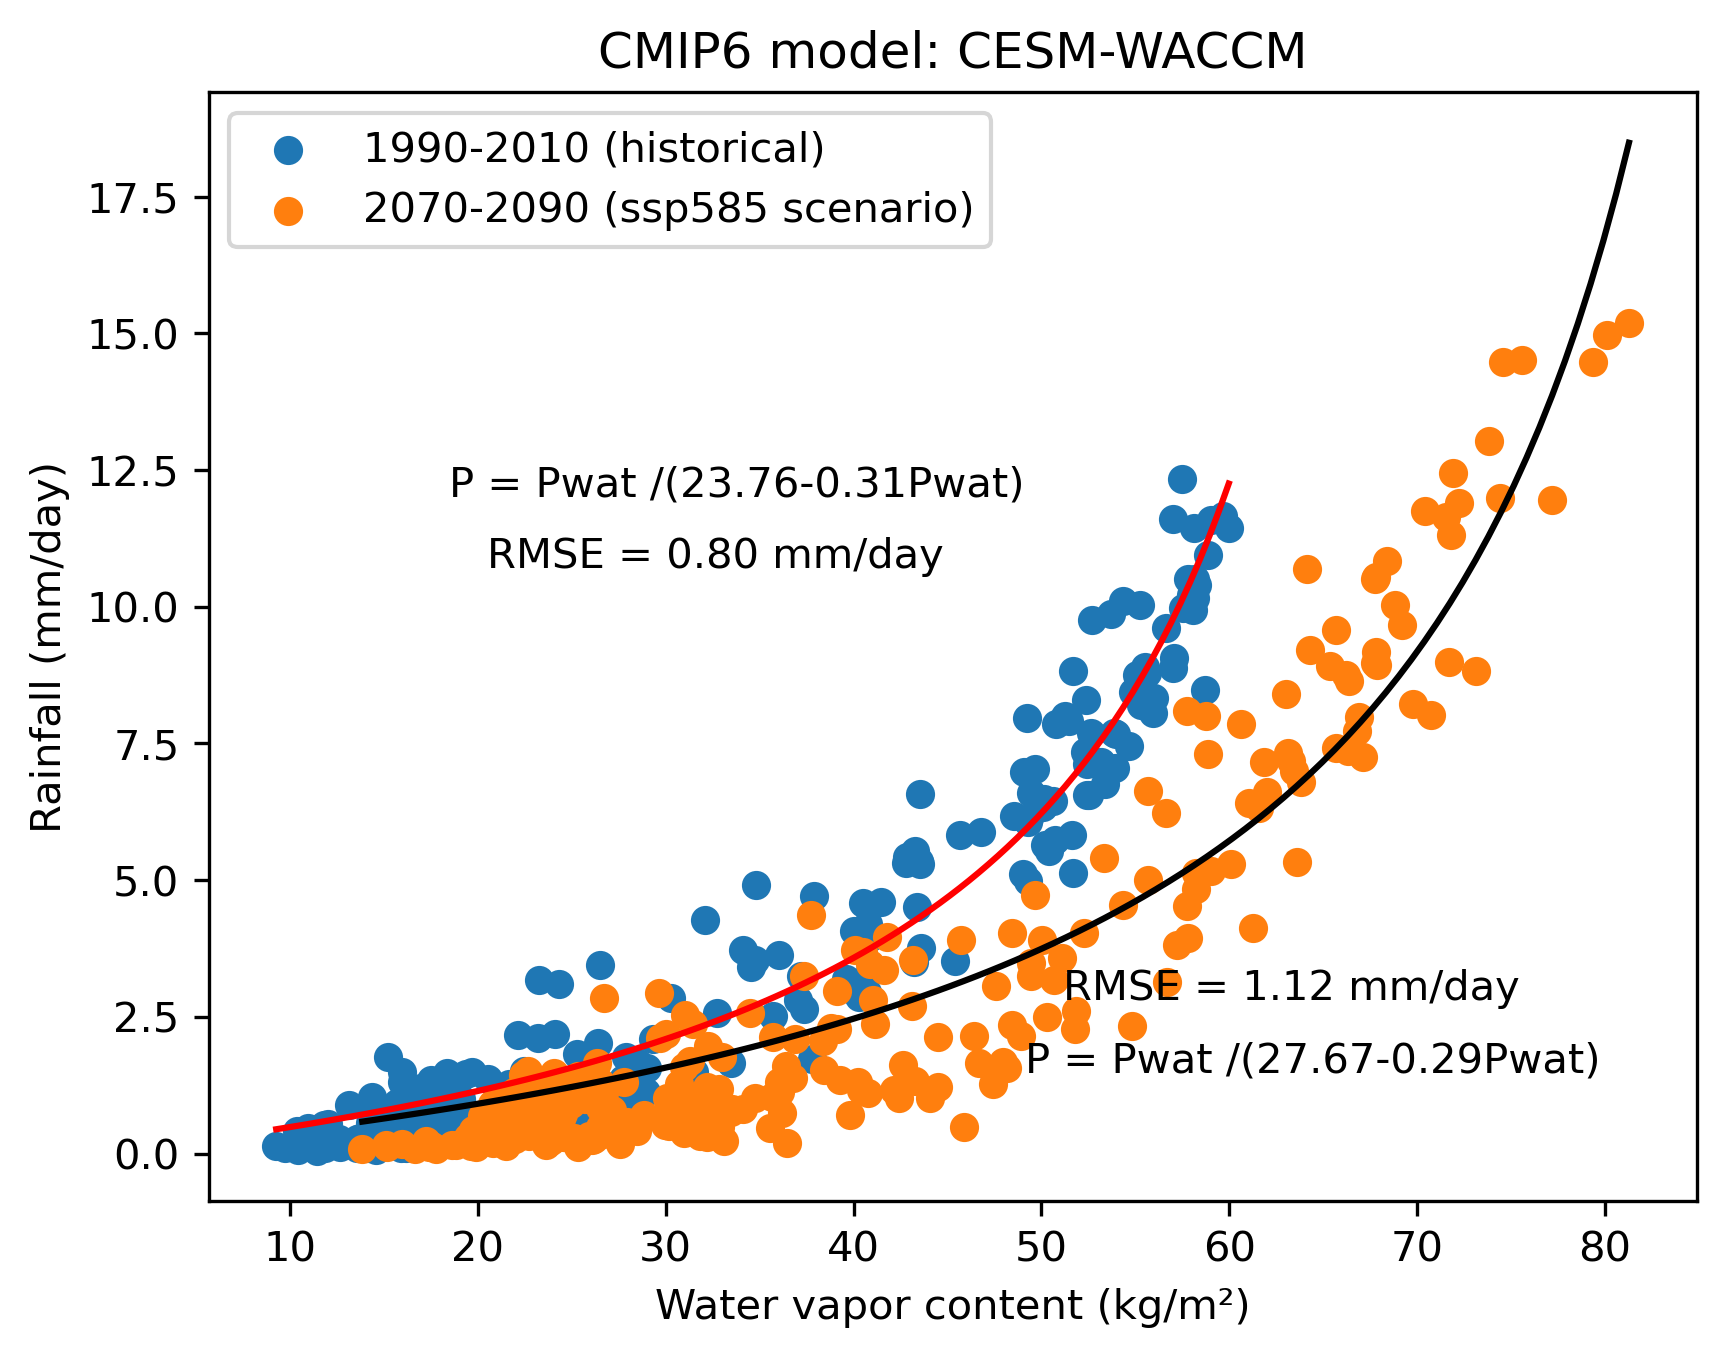

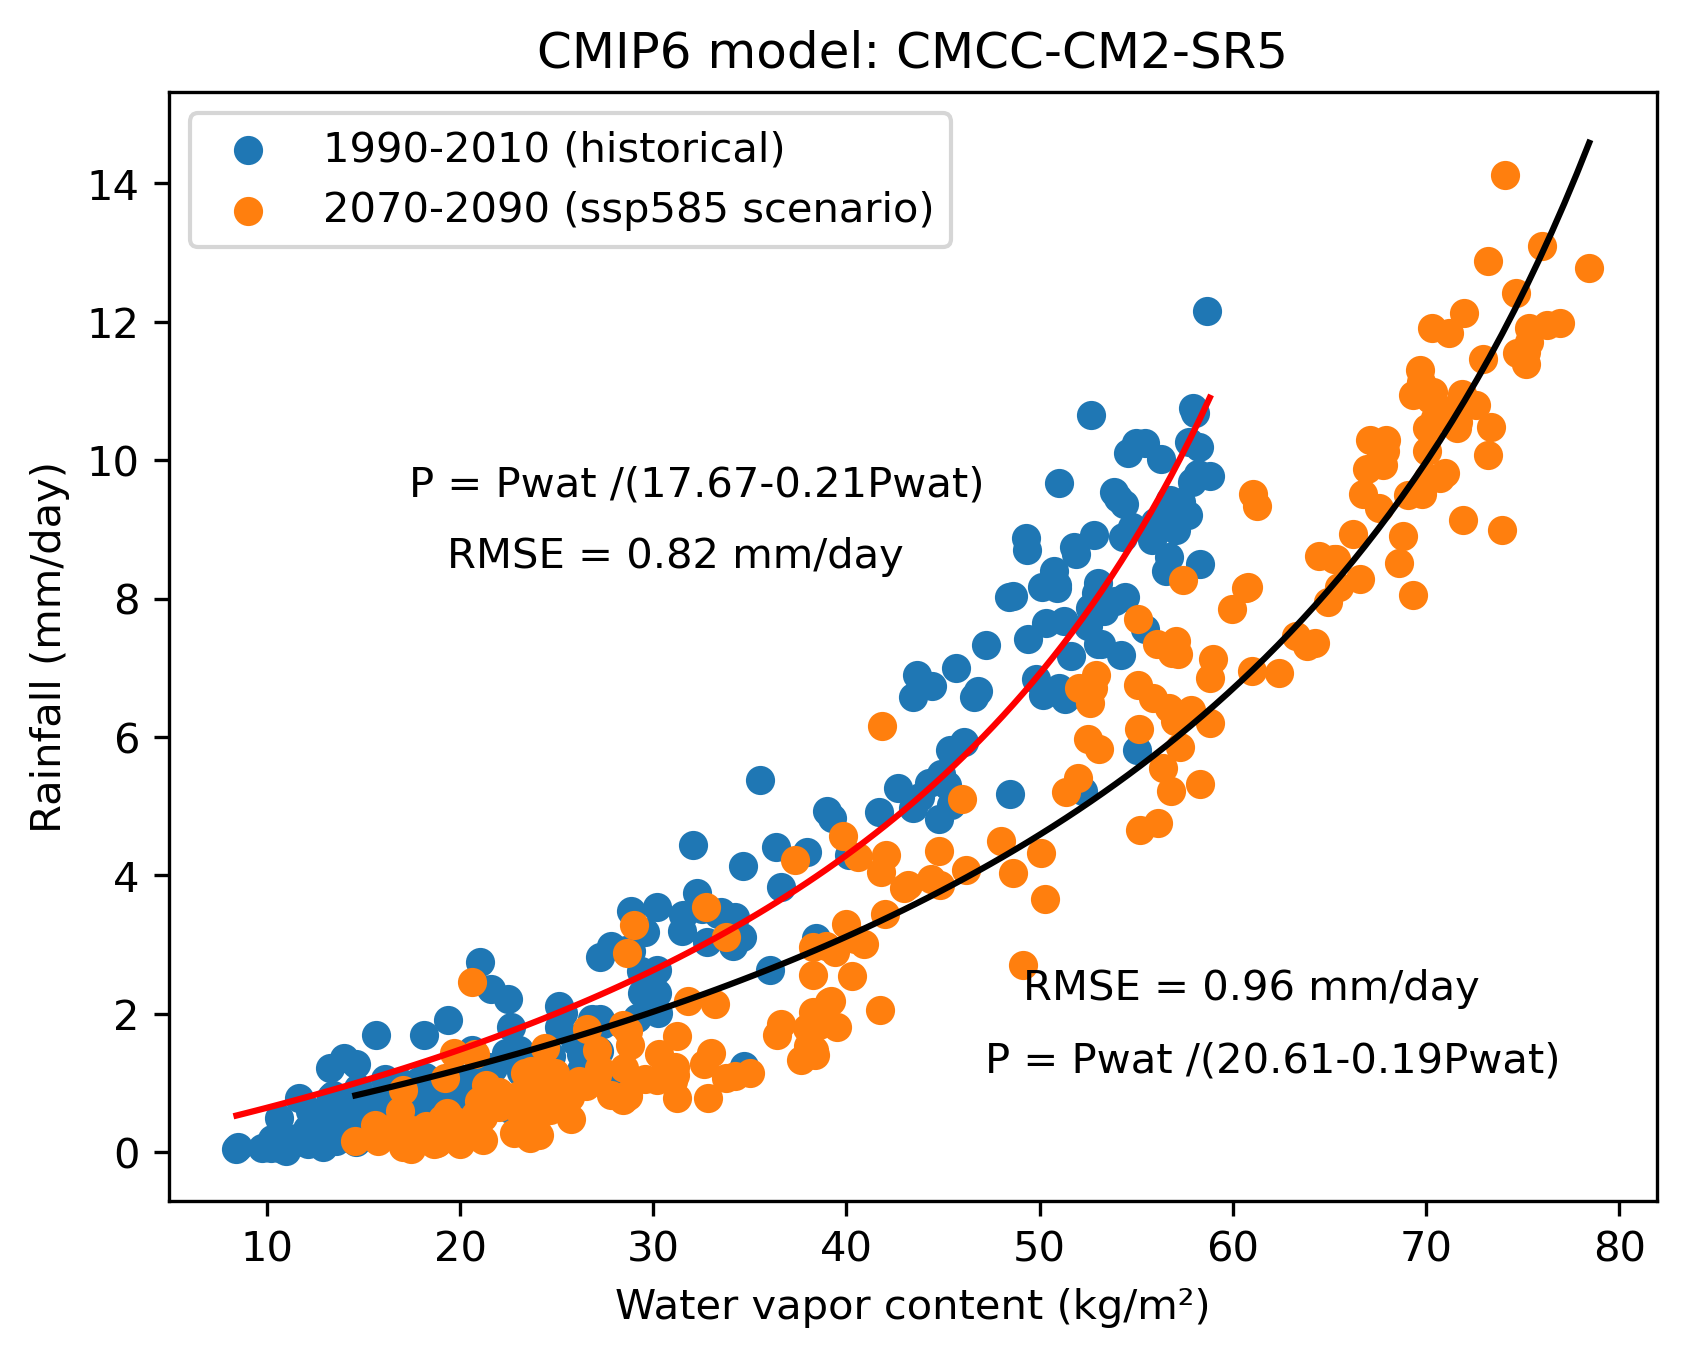

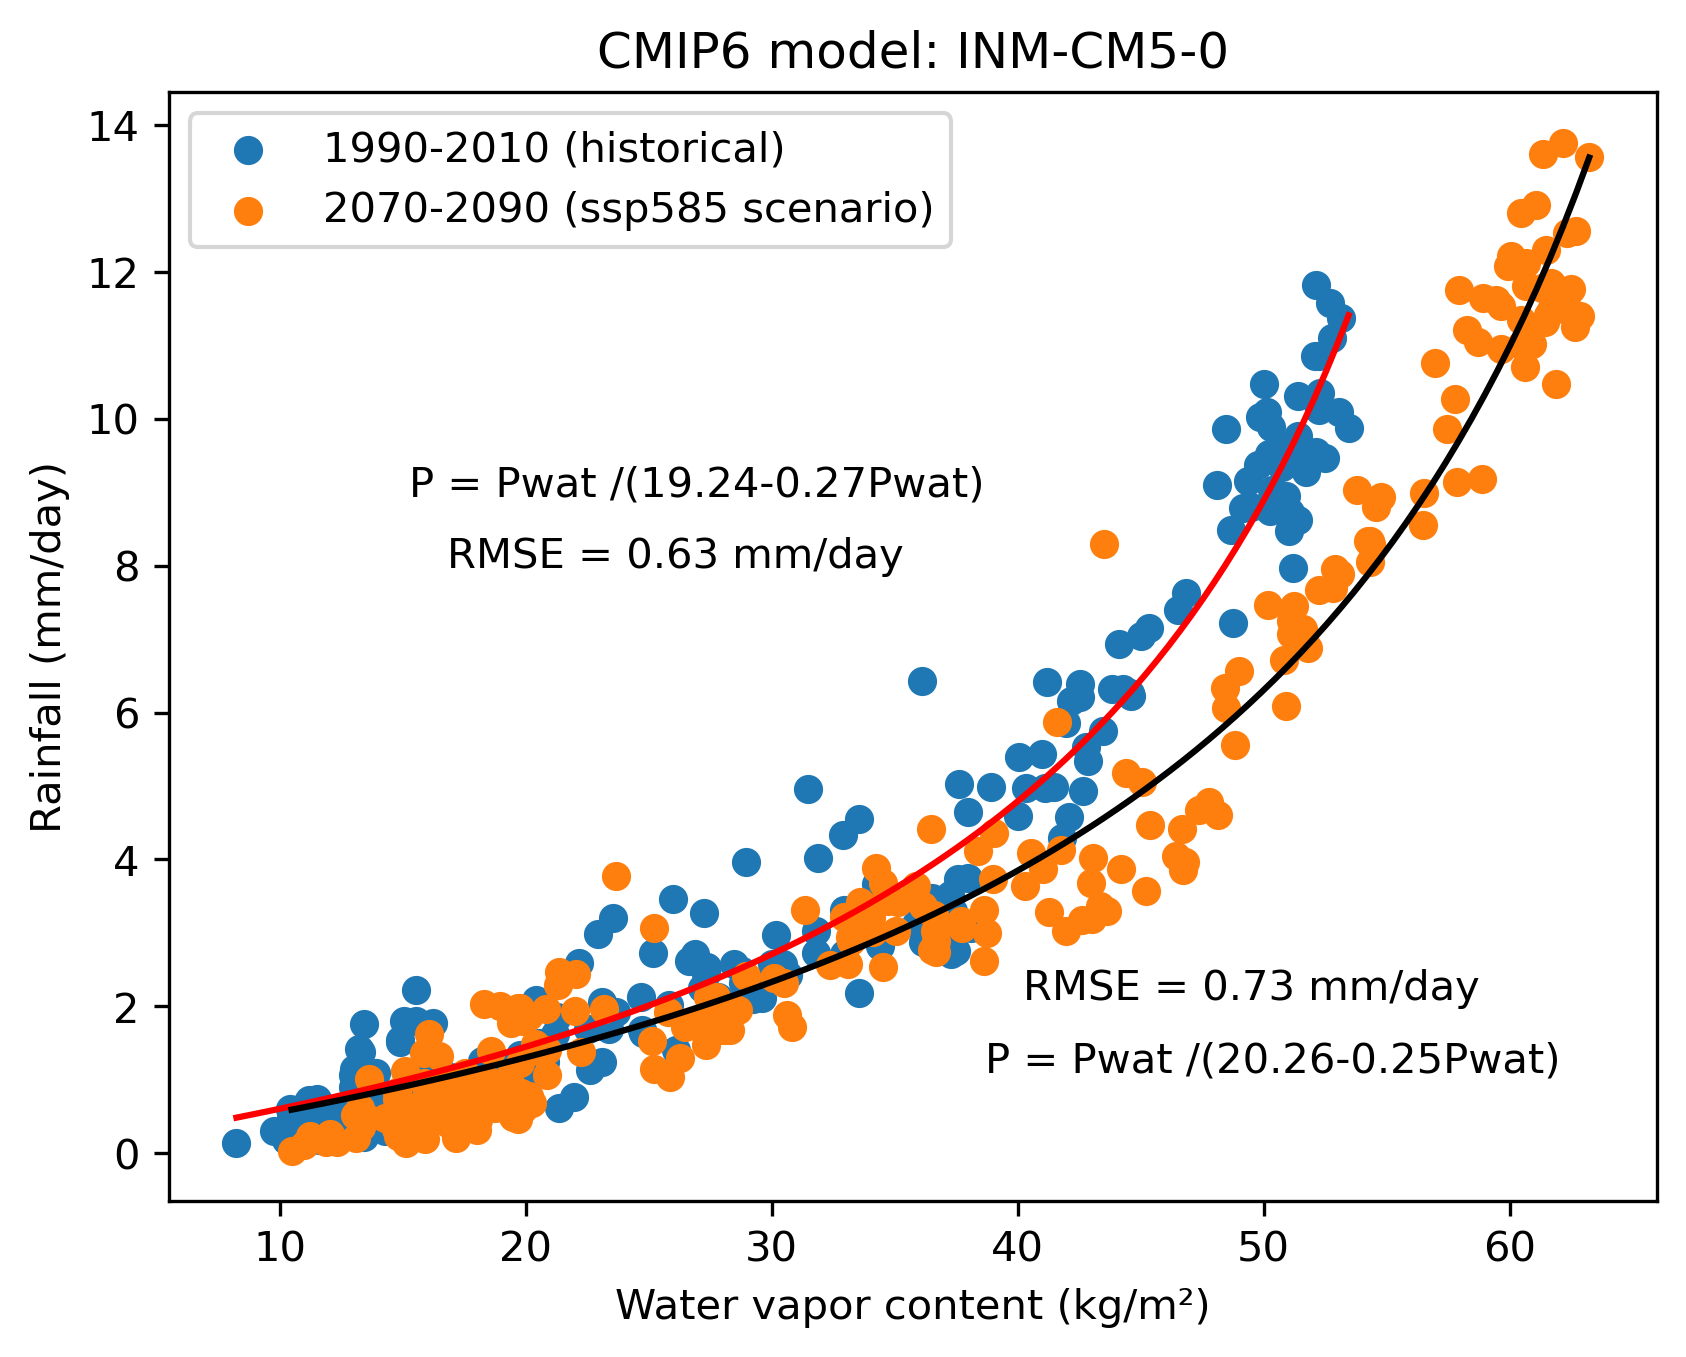

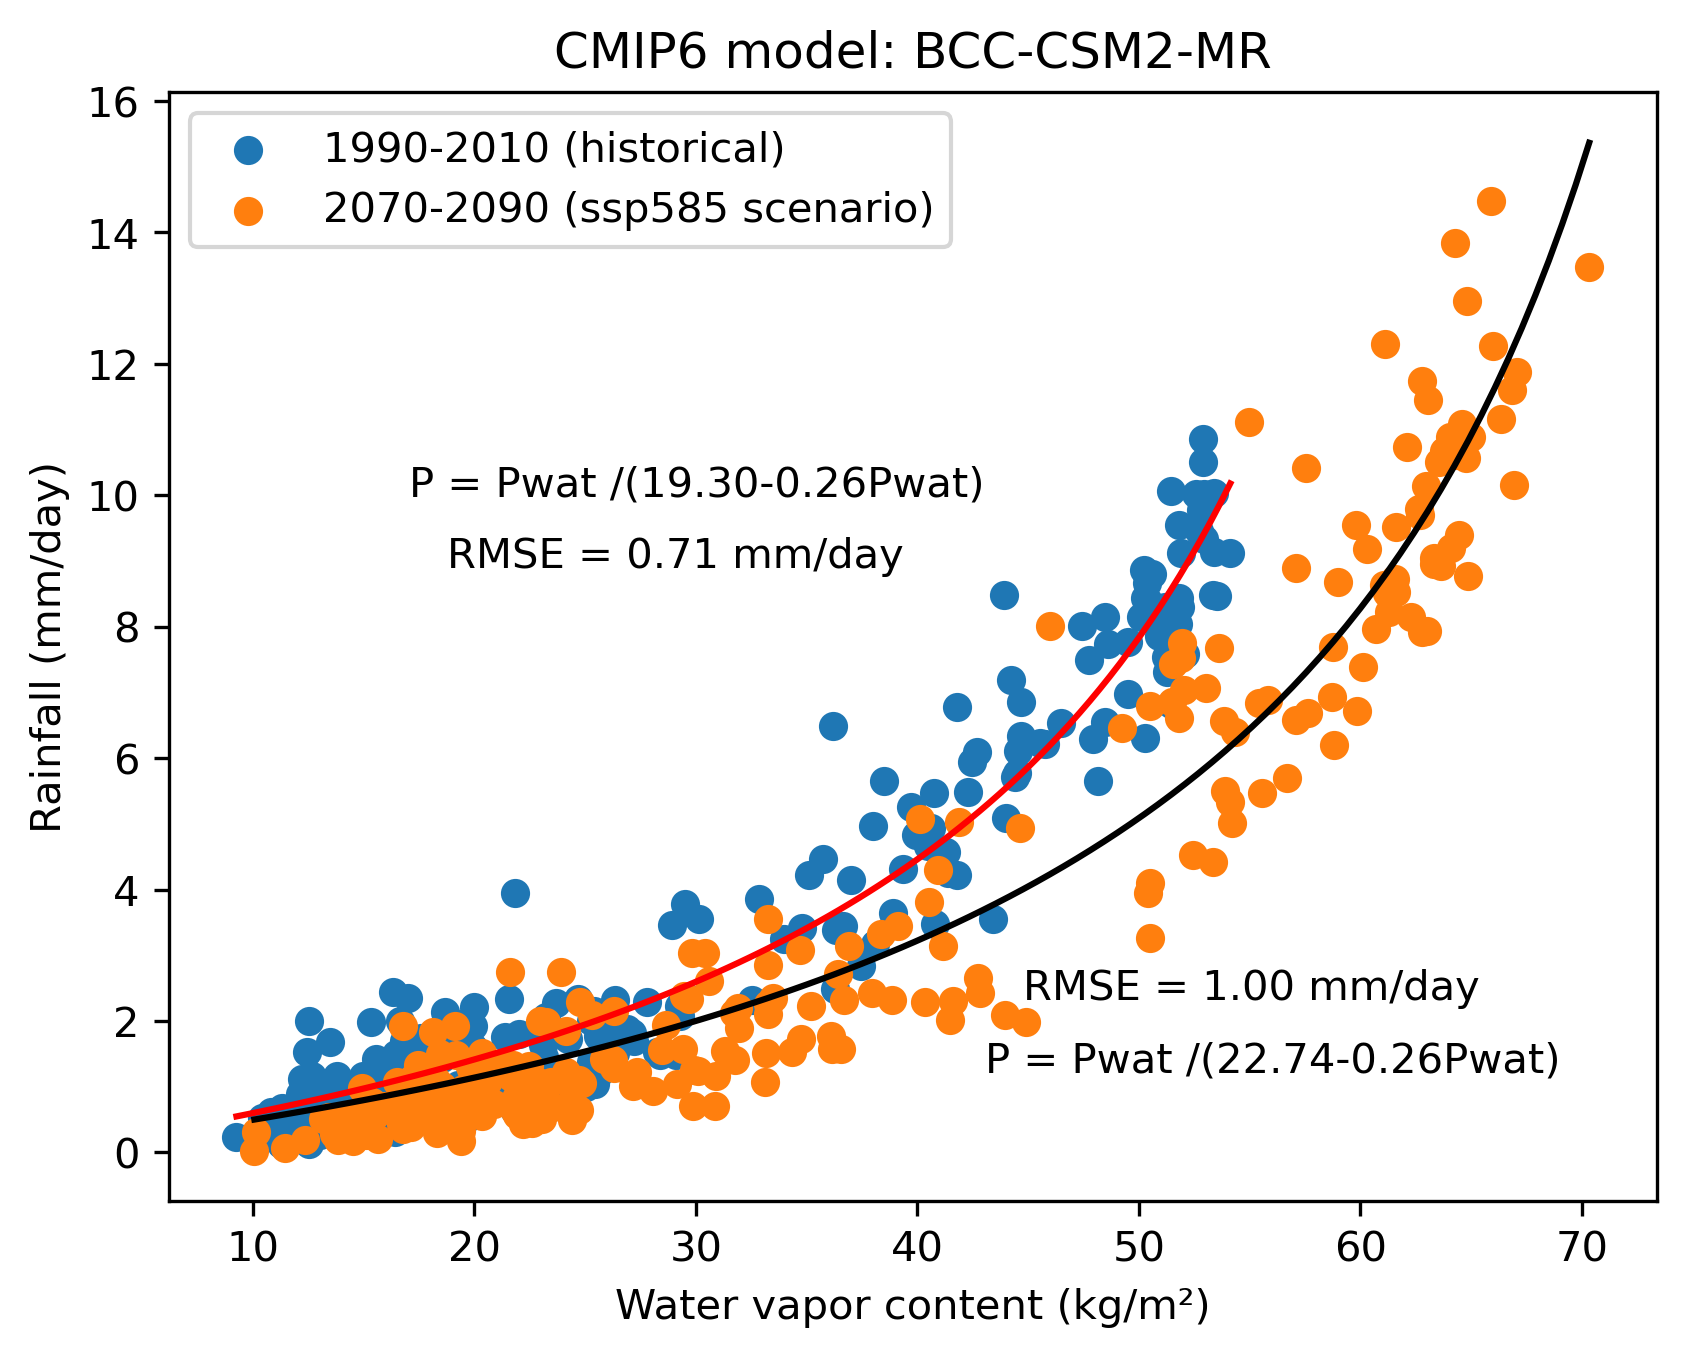

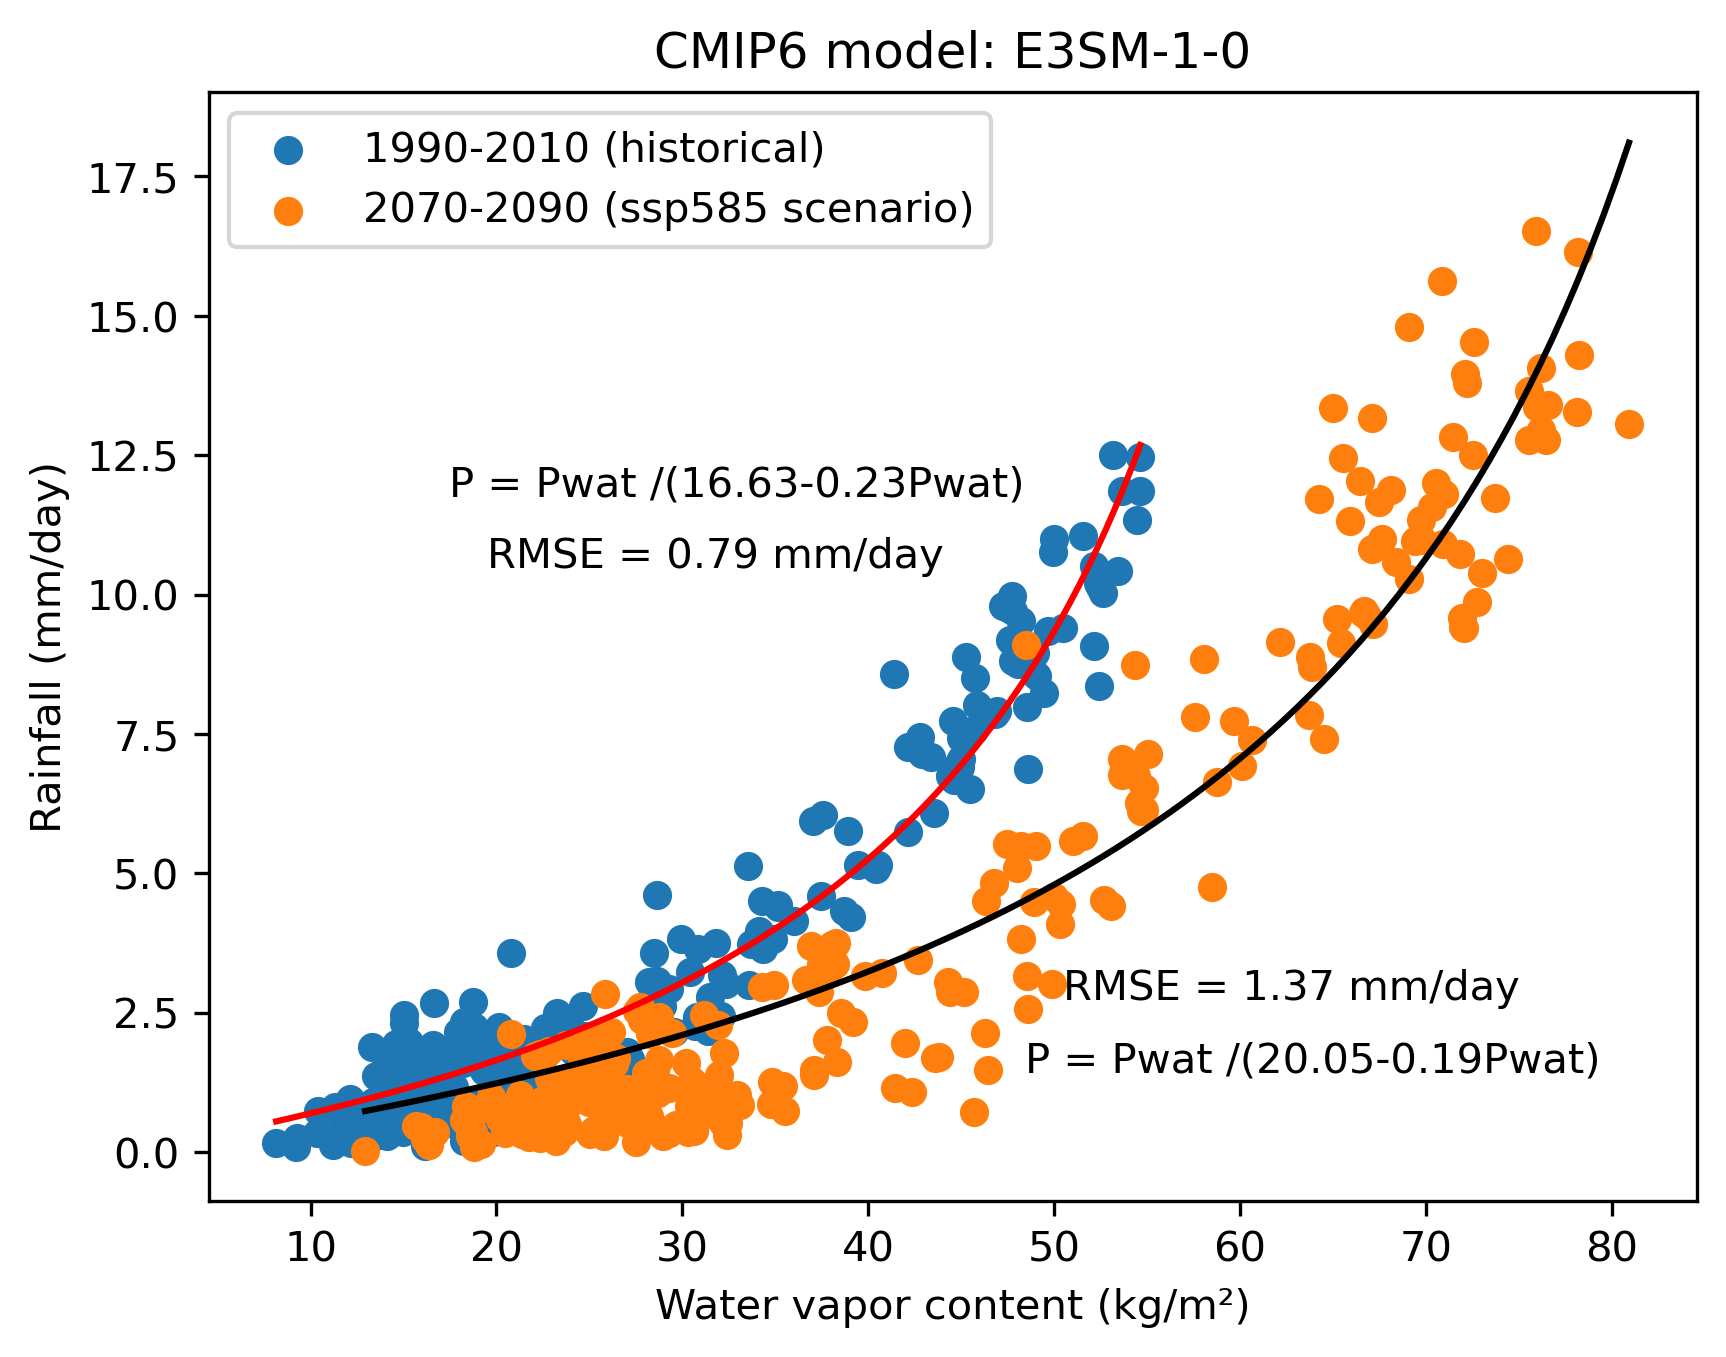

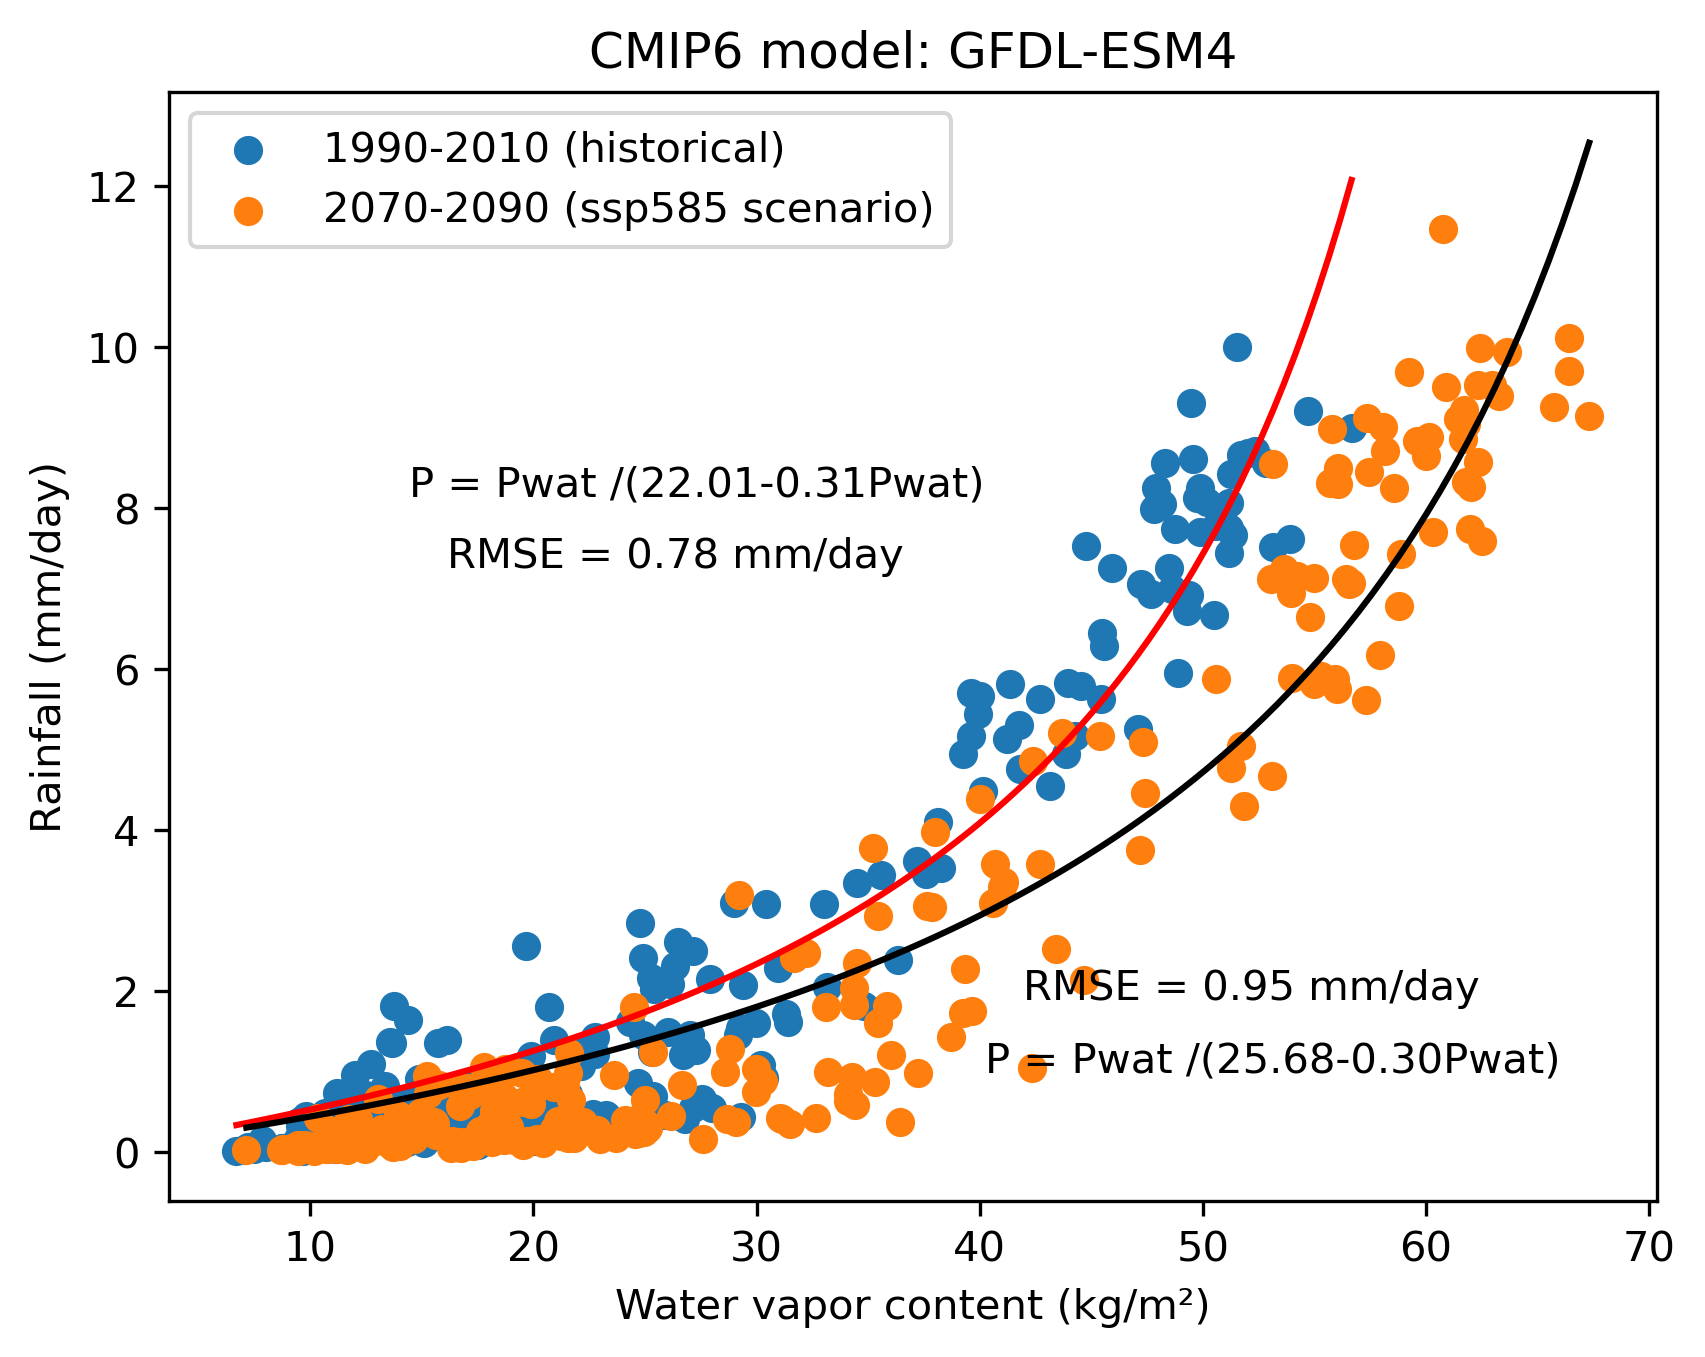

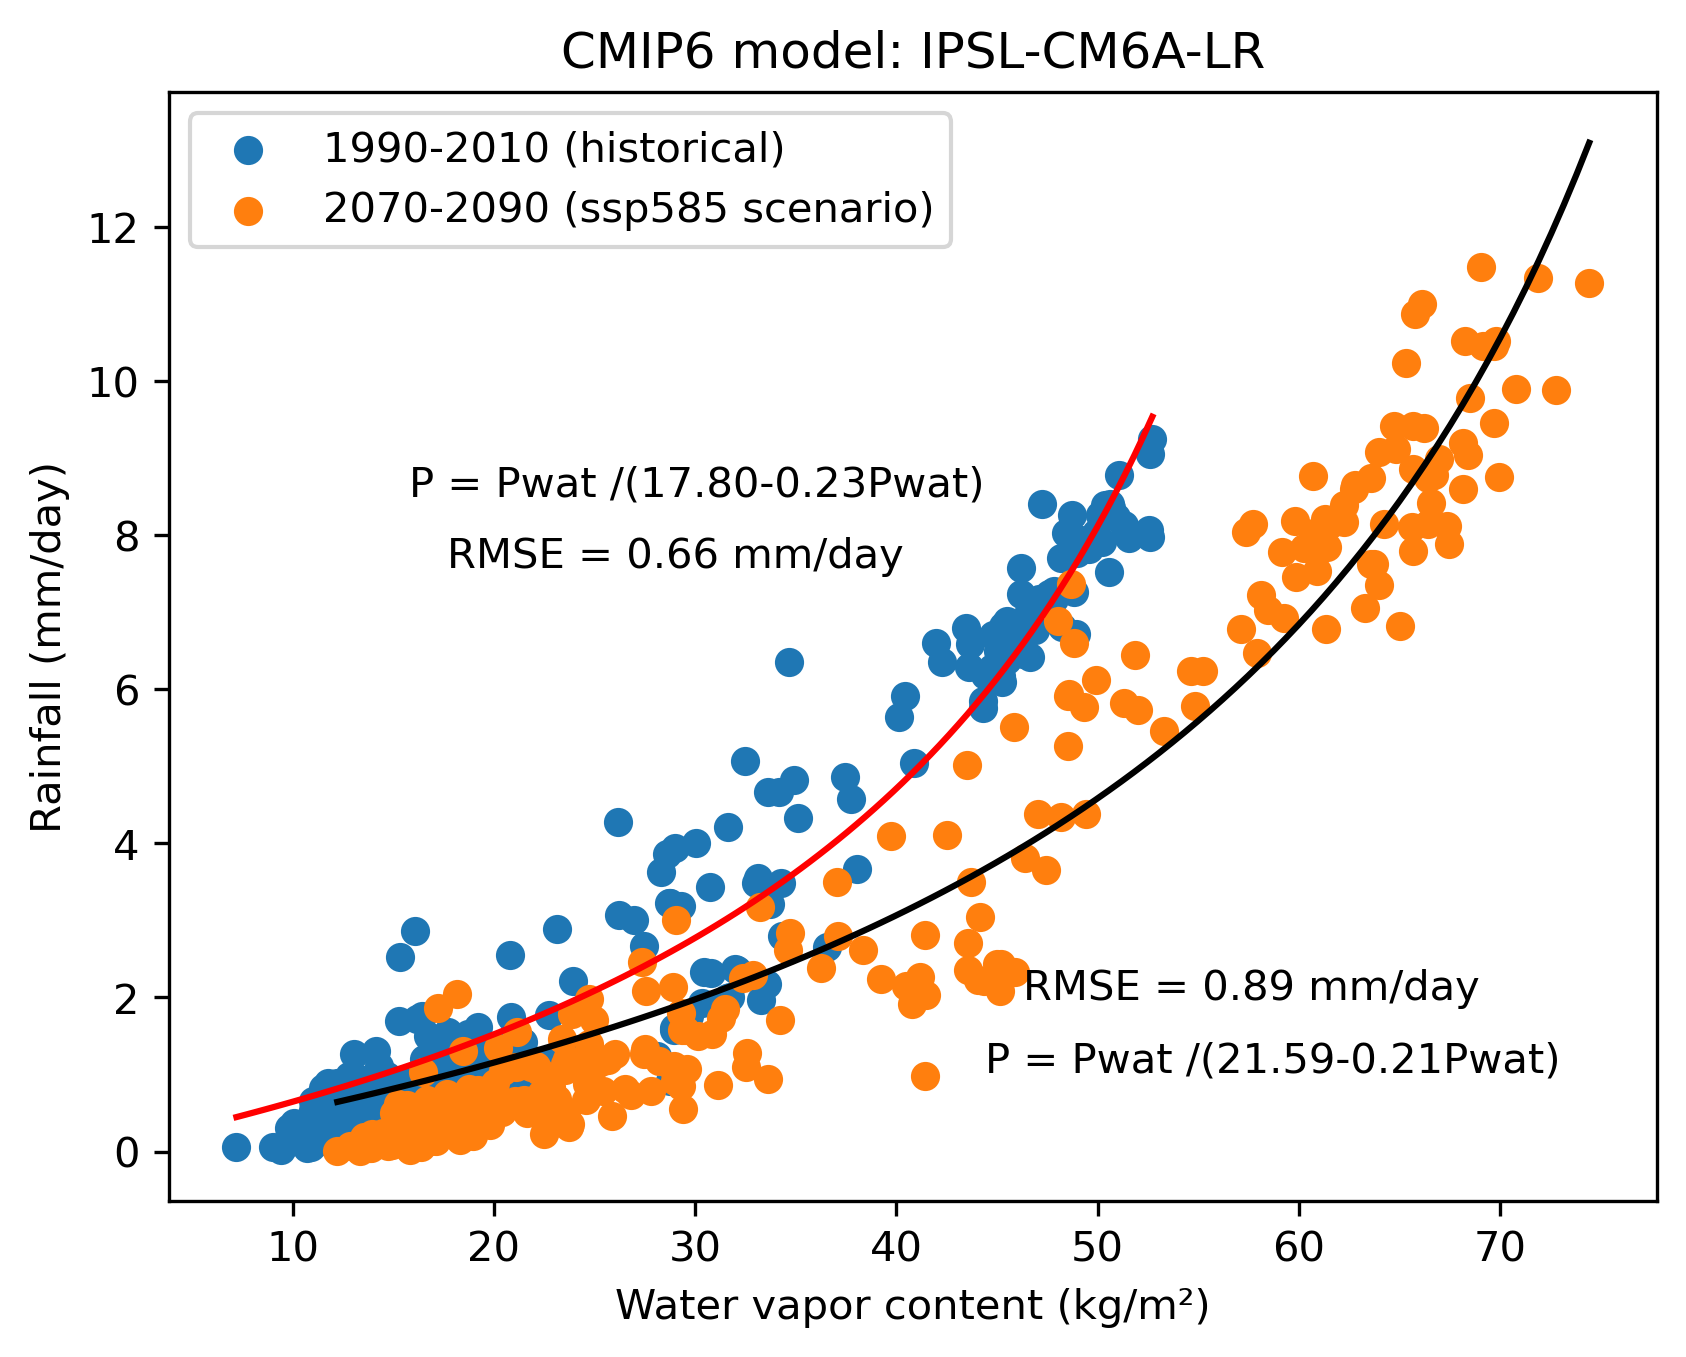

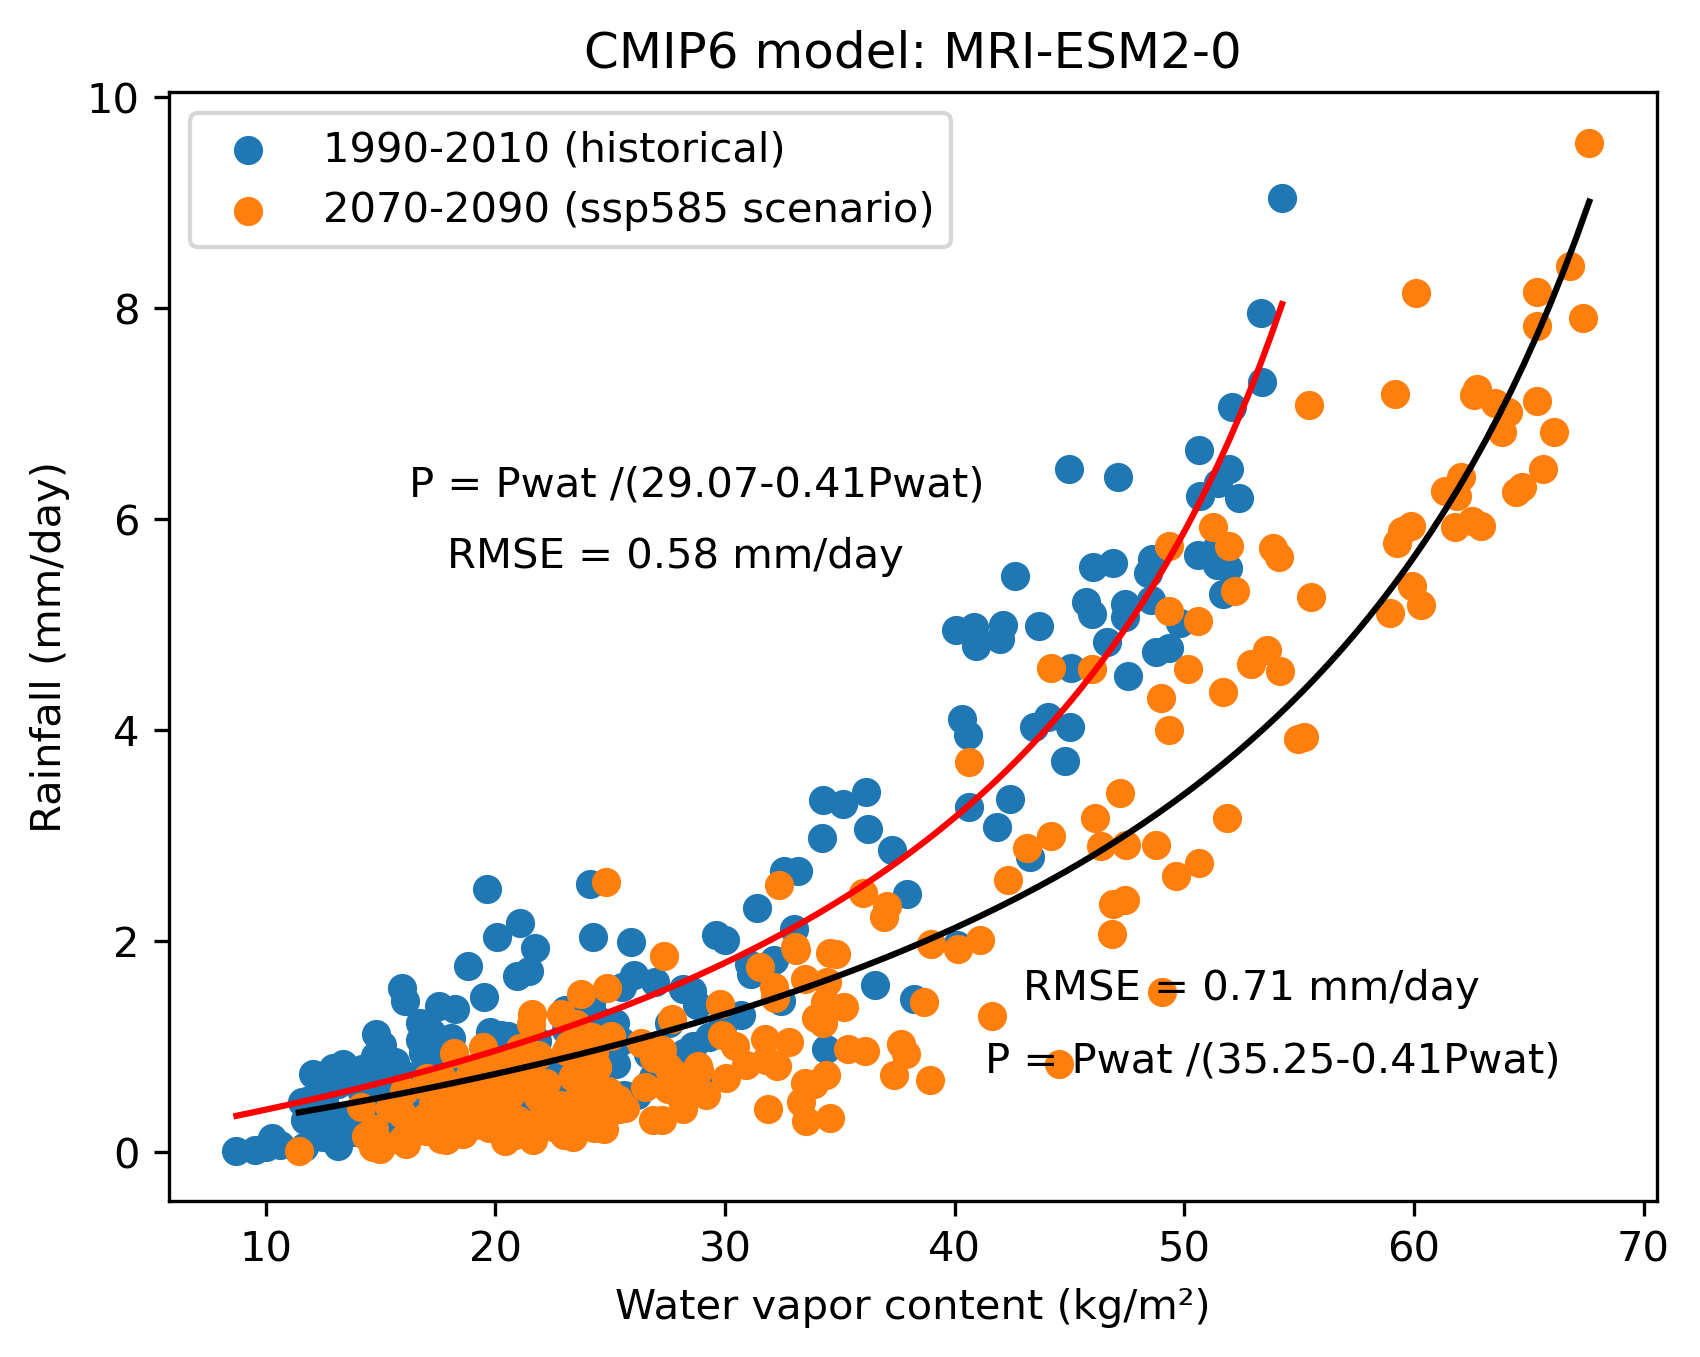

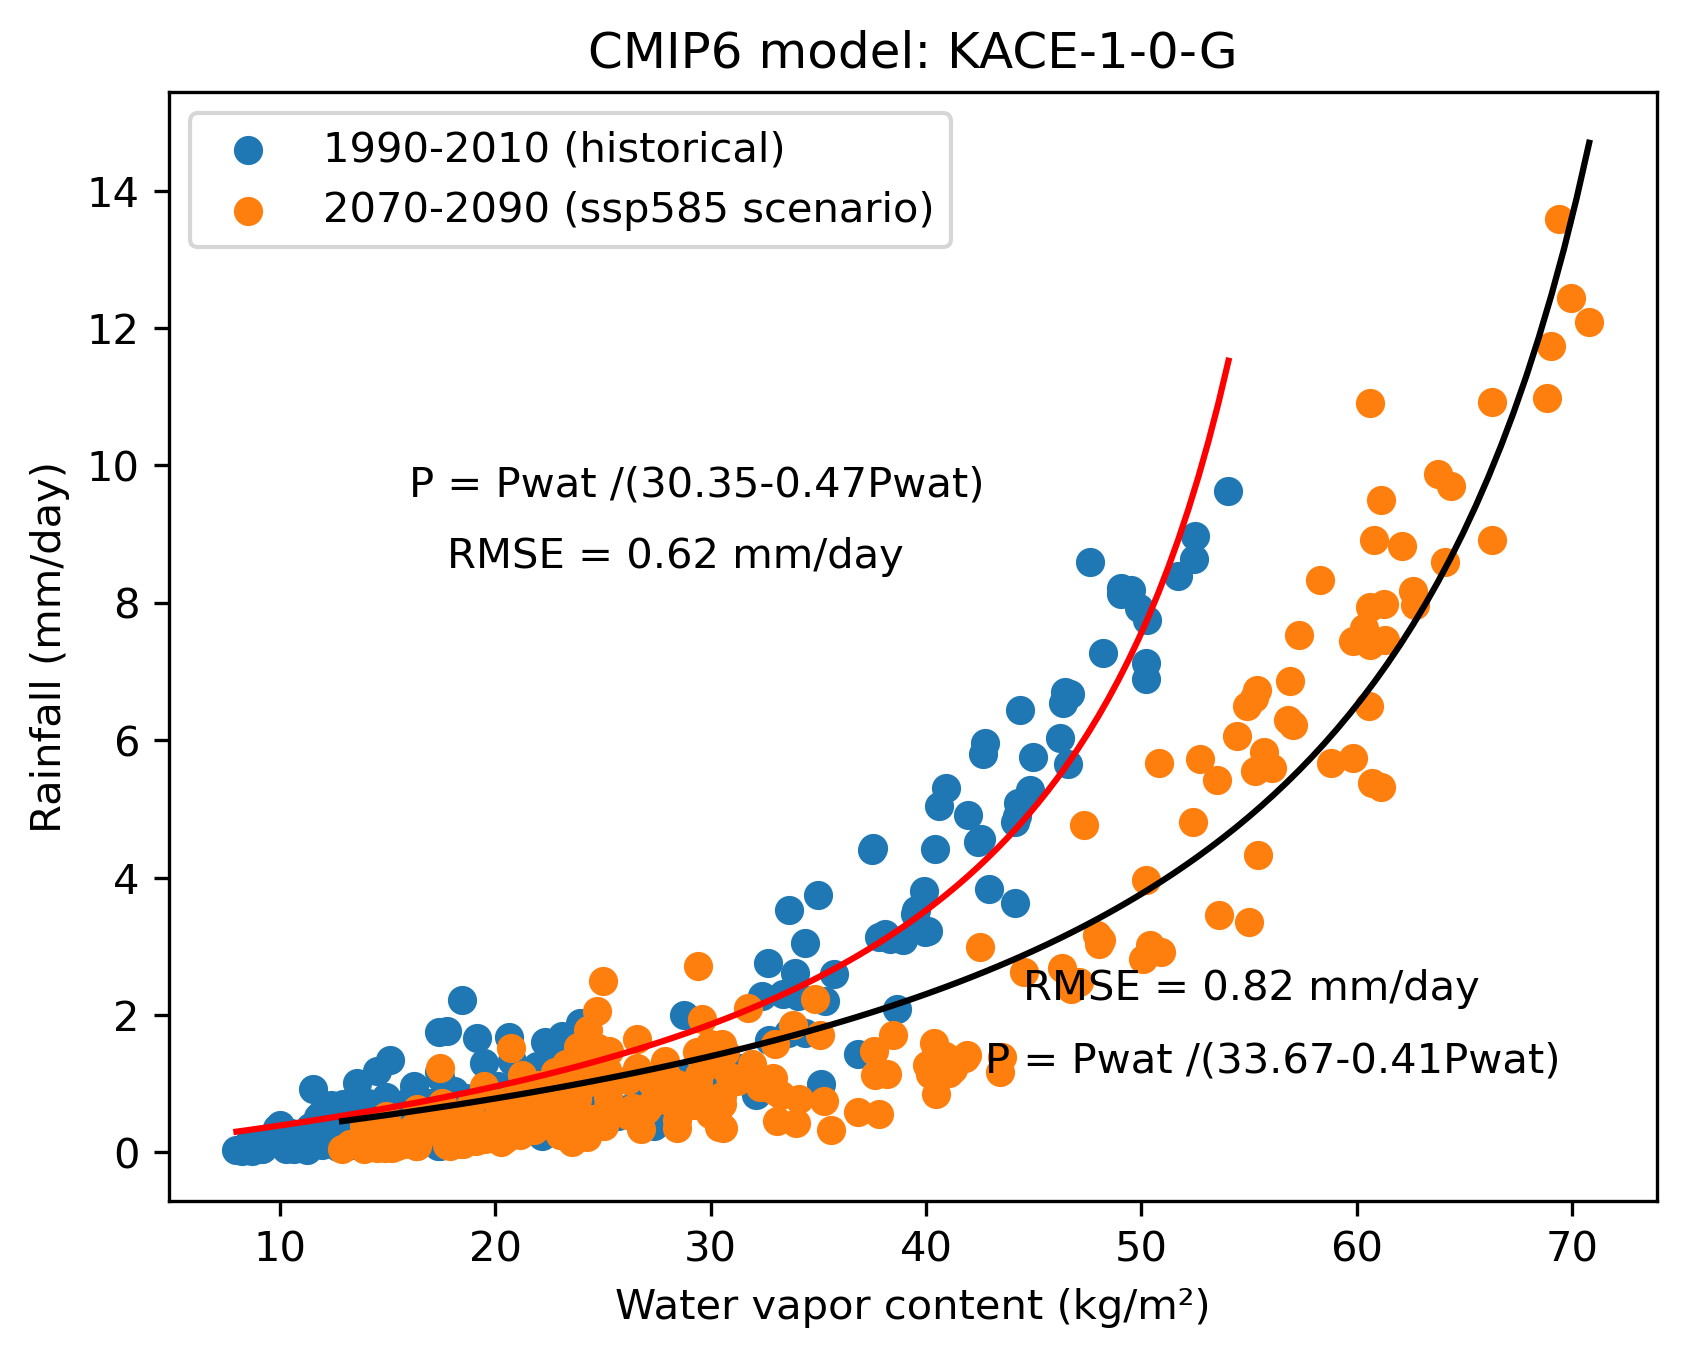

In [30]:
for j in range(len(models)):
    #jjas = models[i].time.dt.month.isin(range(6, 10))
    #clim = models[i].sel(time=jjas) #ds with only JJAS months
    clim=models[j]
    clim2 = clim.sel(lat=slice(10,30), lon=slice(70,90))
    year3='1990'
    year4='2010'
    year7='2070'
    year8='2090'
    grid2 = clim2.sel(time=slice(year3, year4))
    grid4 = clim2.sel(time=slice(year7, year8))
    
    l=[]
    for i in grid2.lon:
        if i>180:
            l.append(i-360)
        else:
            l.append(i)
            
    lon_grid, lat_grid = np.meshgrid(l, grid2.lat)
    mask = globe.is_land(lat_grid, lon_grid)
    
    Pwat2 = grid2.prw.where(mask>0).mean(dim=['lat', 'lon']).squeeze()
    Pr2 = 86400*grid2.pr.where(mask>0).mean(dim=['lat', 'lon']).squeeze()
    Pwat4 = grid4.prw.where(mask>0).mean(dim=['lat', 'lon']).squeeze()
    Pr4 = 86400*grid4.pr.where(mask>0).mean(dim=['lat', 'lon']).squeeze()
    
    x1, y1 = Pwat2.values, Pr2.values
    x2, y2 = Pwat4.values, Pr4.values
    
    def objective(x, a, b):
        return x/(a-b*x)

    p0 = [30, 0.2]
    popt1, _ = curve_fit(objective, x1, y1, p0)
    popt2, _ = curve_fit(objective, x2, y2, p0)
    a1, b1 = popt1
    a2, b2 = popt2

    x_line1 = np.linspace(np.min(x1), np.max(x1), 100)
    x_line2 = np.linspace(np.min(x2), np.max(x2), 100)
    y_line1 = objective(x_line1, a1, b1)
    y_line2 = objective(x_line2, a2, b2)

    pred1 = objective(x1, a1, b1)
    pred2 = objective(x2, a2, b2)

    from sklearn.metrics import mean_squared_error
    rmse1 = mean_squared_error(y1, pred1, squared=False)
    rmse2 = mean_squared_error(y2, pred2, squared=False)
    #print(rmse1)
    #print(rmse2)
    
    plt.scatter(Pwat2, Pr2, label=year3 + '-' + year4 + ' (historical)')
    plt.scatter(Pwat4, Pr4, c='tab:orange', label=year7 + '-' + year8 + ' (ssp585 scenario)')
    plt.plot(x_line1, y_line1, c='r')
    plt.plot(x_line2, y_line2, c='black')
    plt.figtext(0.25, 0.6, 'P = Pwat /(%.2f-%.2fPwat)' % (a1, b1))
    plt.figtext(0.55, 0.2, 'P = Pwat /(%.2f-%.2fPwat)' % (a2, b2))
    plt.figtext(0.27, 0.55, 'RMSE = %.2f mm/day' % (rmse1))
    plt.figtext(0.57, 0.25, 'RMSE = %.2f mm/day' % (rmse2))
    plt.xlabel('Water vapor content (kg/m\u00b2)')
    plt.ylabel('Rainfall (mm/day)')
    plt.legend()
    plt.title('CMIP6 model: ' + names[j])
    #fig1 = plt.gcf()
    plt.show()
    #plt.draw()
    #fig1.savefig(names[i], dpi=1200, bbox_inches="tight")